# STAT2005 Computer Simulation - Workshop 6
## VaR for Portfolio

In this workshop, you will be evaluating various VaR forecast methods on a portfolio and assessing their sensitivities to different assets allocations. 

Let $r_t = \left (r_{1t}, \ldots, r_{Kt} \right )'$ be a $K\times 1$ vector of $K$ asset returns. Let $\mu = \left ( \mu_1, \ldots, \mu_K \right )'$ and $\Omega = \{ \sigma^2_{ij} \}$ such that $\mu_i = \mathbb{E} (r_{it})$, $\sigma^2_{ij} = \mathbb{E} \left [ \left ( r_{it} - \mu_i \right ) \left ( r_{jt} - \mu_j \right ) \right ]$ for $i,j=1,\ldots, K$.

Let $w = \left (w_1, \ldots, w_K \right )'$ be the vector weights for each of the $K$ assets, such that $\mathbf{i}'w=1$ where $\mathbf{i}$ is a vector of 1s. Let $r_{pt}$ be the portfolio return at time $t$ then $ \mathbb{E} \left ( r_{pt} \right ) = w'\mu$ and the variance of the portfolio is $\sigma^2_p = w' \Omega w$. 

For risk-averse investors, they may wish to select the weights to minimize their investment risk. In such case, they can select the weight by solving the following minimization problem:

$$
    \begin{align} 
        w^* =& \underset{w}{\arg\min}\; w'\Omega w \\
        \text{s.t.} \qquad& \mathbf{i}'w = 1.
    \end{align}
$$

<div style="background-color:rgb(255,200,200)">
**Task 1** Show that the weight vector that minimizes the variance of the portfolio is 
$$ w^* =  \Omega^{-1} \mathbf{i} \left (  \mathbf{i}' \Omega^{-1}  \mathbf{i} \right )^{-1} $$ 
</div>

**Solution** The Lagrangian of the optimization problem is 
$$ L = w'\Omega w + \lambda (1-\mathbf{i}' w )$$ 
and the FONC are
$$ \begin{align}
        L_w =& 2\Omega w - \lambda \mathbf{i} = 0 \\
        L_\lambda =& 1-\mathbf{i}' w = 0
    \end{align}
$$
Pre-Multiply the first equation by $w$ gives 
$$2w'\Omega w - \lambda = 0$$ 
Since $w'\mathbf{i} = 1$ from $L_\lambda$ and therefore:
$$ \lambda^* = 2w'\Omega w$$
and substitute $\lambda^*$ in $L_w$ gives 
$$\Omega w = \left (w'\Omega w \right ) \mathbf{i} . $$
This is the FONC for the optimal weight. Substitute $w^*$ into this expression shows that the condition holds for $w^*$. Since the objective function is convex, $w^*$ is unique and it is a local maximum. 

<div style="background-color:rgb(255,200,200)">
<p>**Task 2** Write a function to estimate the expected return and variance of a portfolio from the returns of $K$ assets and a weight vector. </p>

<p>**Hint** Also allow your function to return the estimated mean vector and the variance-covariance matrix of the asset returns. </p> 
</div>

**Solution**

In [99]:
import numpy as np
import scipy as sp
import scipy.stats as sps
import matplotlib.pyplot as plt
import copy as copy
import pandas as pd

In [4]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [12,9]

In [47]:
def portfolio_return(p,w):
    """
    Function to estimate the expected return and variance of a portfolio from the returns of $K$ assets and a weight vector.
    Inputs:
        p: (K,T) numpy array containing the returns of the K assets.  
        w: (K,) numpy array containing the weight for each asset. 
    Outputs:
        r: float. Expected return of the portfolio given w. 
        s: float. Variance of the portfolio given w. 
        m: (K,) numpy array. The estimated means of the K asset returns. 
        omega: (K,K) numpy array. The estimated variance-covariance matrix of the K asset returns. 
    """
    m = np.mean(p,axis=1)
    omega = np.cov(p)
    r = np.dot(w.transpose(), m)
    s = np.dot(w.transpose(), np.dot(omega, w))
    return r,s,m,omega
    

<div style="background-color:rgb(255,200,200)">
**Task 3** Import the data from 'stock201801-Sem1.csv' as a pandas dataframe. Assuming your client would like to invest in these four stocks but he is risk averse. What would be your advice, i.e. what would be your recommended allocation (weights), based on the first 252 observations?  

What are the expected return and risk of the portfolio? 
</div>

**Solution**: First we work out the mean and the variance-covariance matrix of the returns based on the first 252 observations. 

In [79]:
stock = pd.read_csv('stock201801-Sem1.csv', header=0, index_col=0) #import the data
rstock = 100*np.log(stock.dropna()).diff().iloc[1:,:] #calculate the returns. 
w = 0.25*np.ones(rstock.shape[1]) #some arbitrary weight. 
r,s,m,omega = portfolio_return(rstock.values[0:252].transpose(), w) #r,s are irrelavant at this point. 

In [80]:
m, omega

(array([ 0.12017666,  0.07325789,  0.03375863, -0.03793283]),
 array([[25.52151741,  0.3997373 ,  1.30559391,  0.83495561],
        [ 0.3997373 ,  3.08874175,  1.04622393,  0.40928323],
        [ 1.30559391,  1.04622393,  2.49008048,  0.69859144],
        [ 0.83495561,  0.40928323,  0.69859144,  1.11830965]]))

Write a function to calculate the optimal weight based on $\Omega$ estimates. 

In [81]:
def optimal_weight(omega):
    """
    Function to return the optimal weights based on the objective function as defined in Task 1. 
    Inputs:
        omega: (K,K) numpy array. Containing the variance-covariance matrix of asset returns. 
    Output:
        w: (K,) numpy array. Optimal weight. 
    """
    K = omega.shape[0]
    i = np.ones(K)
    invO = np.linalg.inv(omega)
    A = np.dot(invO, i) 
    B = float(np.dot(i.transpose(), A))
    return A/B 

Check that it works... 

In [82]:
w = optimal_weight(omega)
w, sum(w)

(array([0.00573475, 0.17663243, 0.10309844, 0.71453438]), 1.0)

In [83]:
r,s,m,omega = portfolio_return(rstock.values[0:252].transpose(), w)
r,np.power(s,0.5)

(-0.009994944639906345, 0.9737429520780946)

So the expected return is 0.04% with 1.61 standard deviation. 

<div style="background-color:rgb(255,200,200)">
<p>**Task 4** Given the risk aversion of your client, he would like to know the worse case scenario assuming he is going to allocate his investment following your advice. Using historical simulation, calculate the 1% VaR for the remaining sample given the optimal weight vector. </p>

<p>How well does the VaR perform? </p>
</div>

**Solution** We first create the time series of the portfolio based on the weight 

In [85]:
rstock.columns

Index(['AAPL', 'HPQ', 'INTC', 'MSFT', 'Portfolio'], dtype='object')

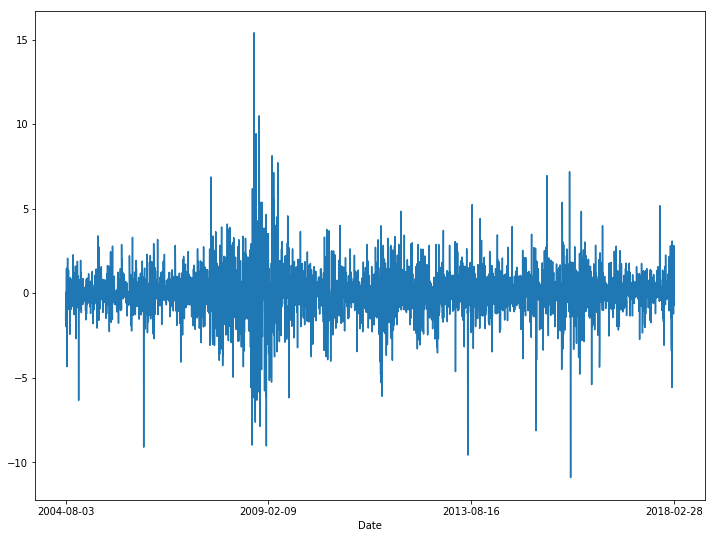

In [127]:
select = [int(i) for i in np.linspace(0,rstock.shape[0]-1,4)]
rstock['Portfolio'] = np.dot(rstock[['AAPL', 'HPQ', 'INTC', 'MSFT']].values, w)
rstock['Portfolio'].plot(xticks=select)

In [101]:
def HS_VaR(s, subsample, alpha=0.01, fixedwindows=False):
    """
    Function to construct VaR via historical simulation assuming constant mean and variance. 
    Inputs:
        s: (T,) numpy array containing financial returns data. 
        subample: float in [0,1]. Propotion of the sample to be used for construction the initial VaR. 
        alpha: float in [0,1]. Significant level. 
        fixedwindows: boolean. If true, the number of observations for calculating the critical value is fixed otherwise, we have a rolling windows. 
    Output:
        sT: int. The observation where the forecast starts. 
        VaR: (T,) numpy array containing the fitted and forecast VaR. 
    
    """
    T = s.shape[0]
    sT = int(np.floor(subsample*T))
    r = copy.copy(s[0:sT])
    VaR = np.zeros(T)
    r.sort()
    index = int(np.floor(alpha*sT))
    VaR[0:sT] = r[index]
    for t in np.arange(sT,T):
        if fixedwindows is False:
            r = copy.copy(s[0:t])
            r.sort()
            index = int(np.floor(alpha*t))
        else:
            r = copy.copy(s[t-sT:t])
            r.sort()
            index = int(np.floor(alpha*sT))
        VaR[t] = r[index]
    return sT, VaR

In [128]:
sub = 252/rstock.shape[0]
sT, rstock['VaR_Portfolio_rolling'] = HS_VaR(rstock['Portfolio'].values, subsample=sub, fixedwindows=True)
sT, rstock['VaR_Portfolio_recursive'] = HS_VaR(rstock['Portfolio'].values, subsample=sub, fixedwindows=False)

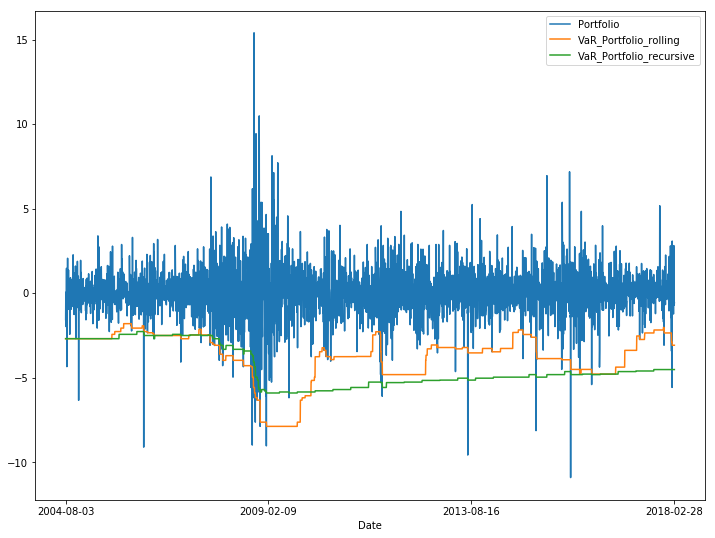

In [129]:
rstock[['Portfolio', 'VaR_Portfolio_rolling', 'VaR_Portfolio_recursive']].plot(xticks=select)

In terms of performance. 

In [130]:
backtest = pd.DataFrame(index=['VaR Violations'])
backtest['rolling'] = 100*sum(rstock['Portfolio'].values[sT:] < rstock['VaR_Portfolio_rolling'].values[sT:])/(rstock.shape[0]-sT)
backtest['recursive'] = 100*sum(rstock['Portfolio'].values[sT:] < rstock['VaR_Portfolio_recursive'].values[sT:])/(rstock.shape[0]-sT)
backtest.transpose()

,VaR Violations
rolling,1.738306
recursive,1.327434


For the out-of-sample forecast, recursive seems to perform better than rolling but both of them led to higher percentage of violation than the target of 1%, 